In [1]:
import RFmodel
import FileProcessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
model = RFmodel.ModelClass()                 
fileProcessing=FileProcessing.FileProcessing()

In [3]:
file_name='Cleaned_NGSIM_Data3'
ngsim1=fileProcessing.read_input(file_name)  

original File path: c:\Users\neels\Desktop\Capstone\carfollowing\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\neels\Desktop\Capstone\carfollowing\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


In [4]:
ngsim = model.preprocessing(ngsim1,0.1)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.1)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


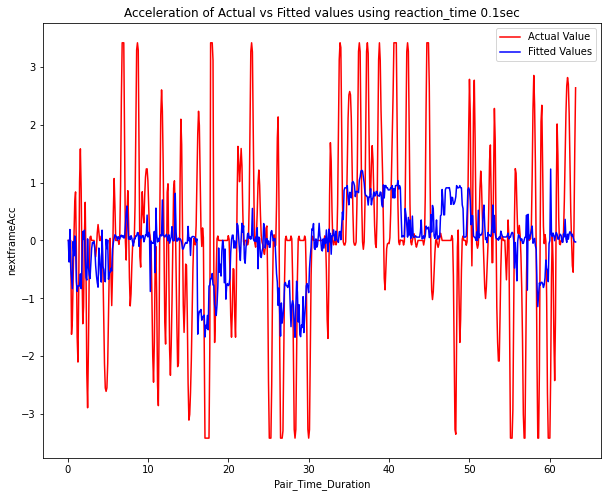

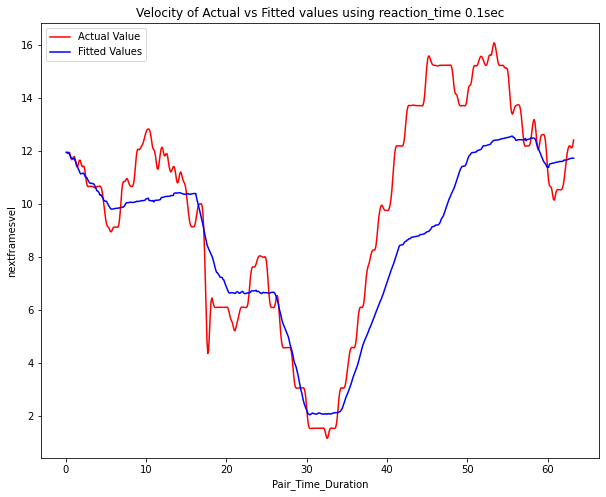

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [5]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.1sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.1sec')

In [6]:
ngsim = model.preprocessing(ngsim1,0.4)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.4)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


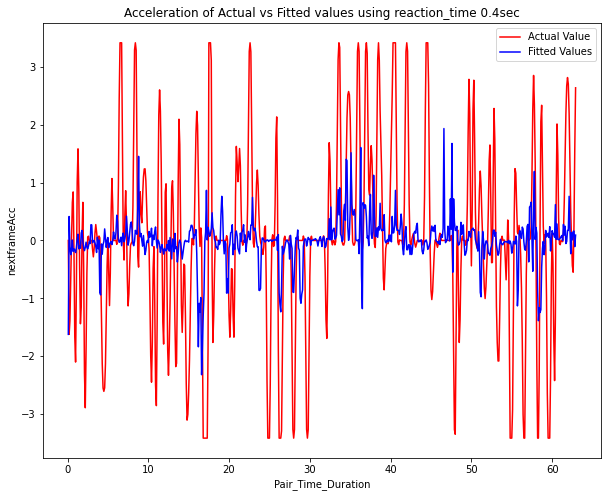

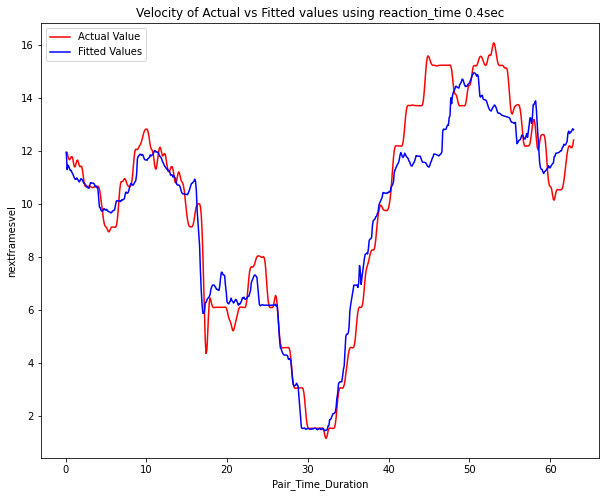

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.4sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.4sec')

In [8]:
ngsim = model.preprocessing(ngsim1,0.5)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.5)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


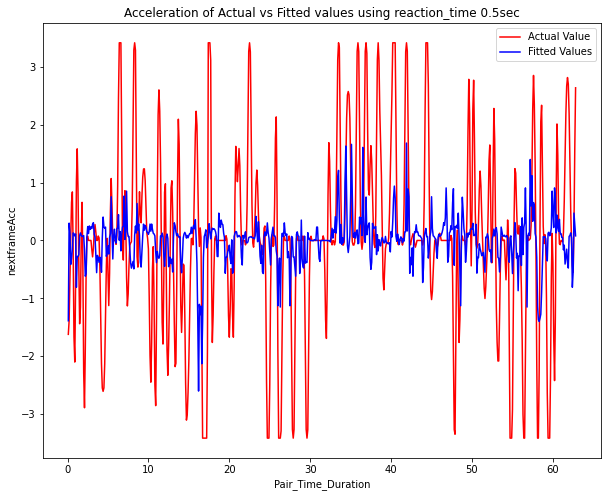

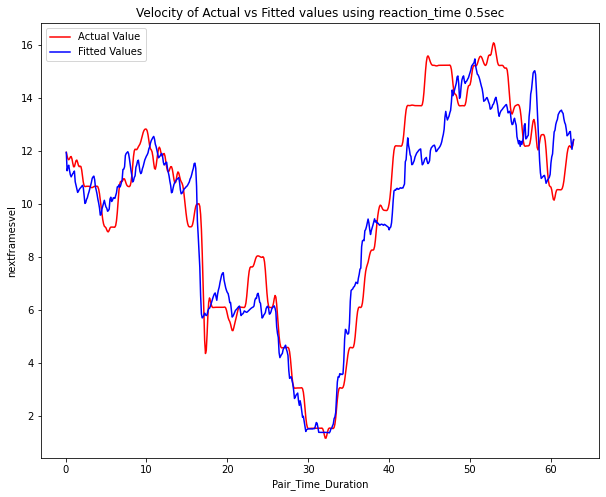

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.5sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.5sec')

In [10]:
ngsim = model.preprocessing(ngsim1,0.8)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,0.8)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


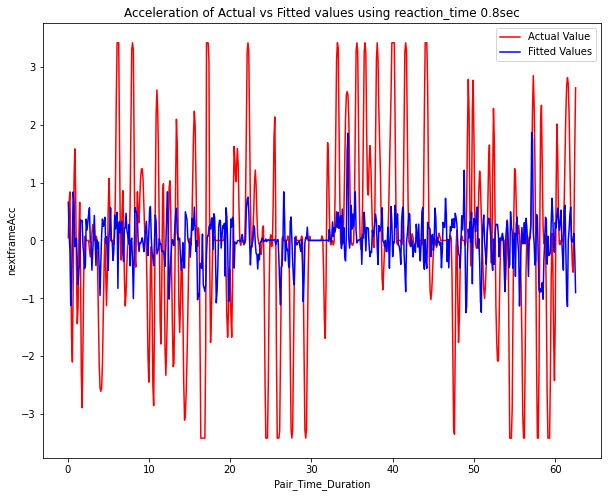

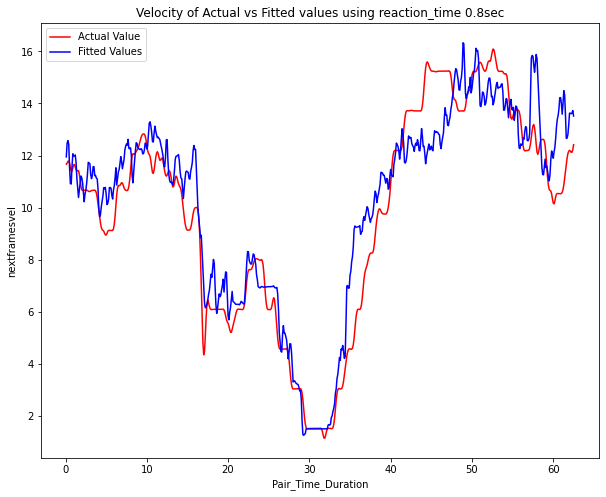

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.8sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.8sec')

In [12]:
ngsim = model.preprocessing(ngsim1,1)
train_pair = model.select_training_pairs(ngsim)
train,test = model.split_df_into_train_test(ngsim,train_pair)
X_train, y_train, X_test, y_test,rf = model.fit_rfmodel(train,test,150)
p= model.prediction_test_pairs(test,0,6)
print(p)
F = model.prediction(test,p,'nextframeAcc',rf,1)

['1978-1984', '1987-1996', '2162-2170', '2190-2200', '2194-2207', '2399-2419']


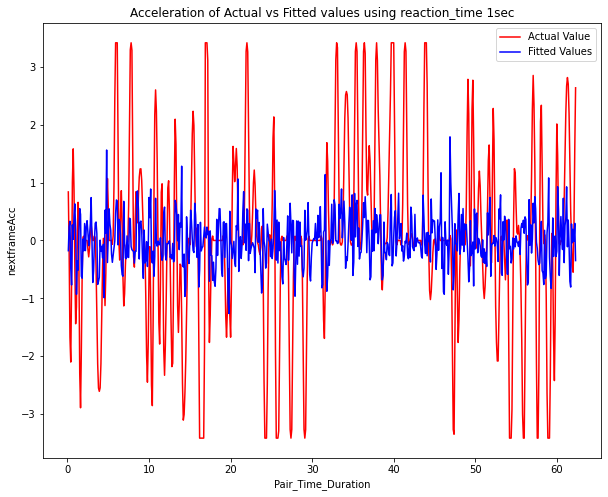

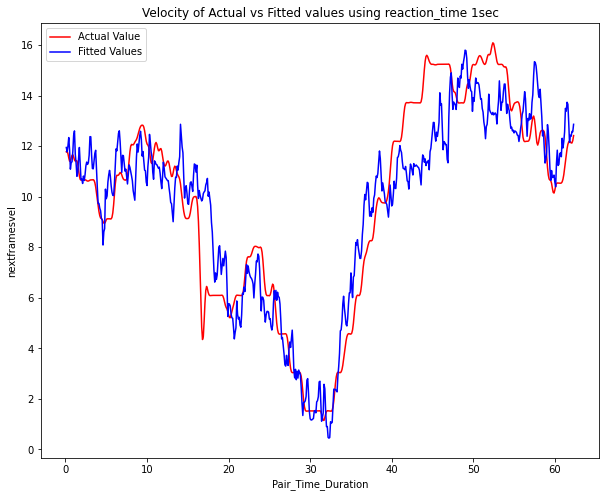

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:
F1 = F[F["L-F_Pair"] == "1978-1984"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 1sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 1sec')